#### Problem Statement

We all know that when we visit an e-commerce or TV series website or even YouTube we see a separate suggestion box, where in they show some content which you might like. These are mainly based on the content that you have consumed on their website previously. These are called as Recommendation engine. 

Now consider you have been running a start up since last one year and now you have been able to gather some customer data and you want to build a recommendation engine. Based on certain features you have to cluster the customers into two different groups so that you can recommend the correct products based on the customer’s cluster.



#### Challenge

Your work is to build a predictive model to predict the category of the customer. You have to predict the column : “customer_category”
You need to upload a presentation proposal addressing the following questions:
What are the pros & cons of recommendation by this approach?

Propose an architecture that will work more efficiently when building a recommendation engine for an e-commerce platform

#### Business Objective

    1. No low latency requirement
    2. Error not very critical but should be in respectable limit
    3. Interpretibility is important on why a person was classified into a category based on which features

#### Machine Learning Problem Formulation

##### Data

Column	- Description
1. customer_visit_score	- a score based on how regularly the customer visits the website
2. customer_product_search_score - 	quality or price range of product that the customer searches for For ex: a customer  searching for a laptop will have more weightage than someone looking for a book
3. customer_ctr_score - 	how many of the searched links does the customer click
4. customer_stay_score - 	a score based on the time spent on an avg. by the customer
5. customer_frequency_score - 	a score based on how many times in a day the customer visit the website
6. customer_product_variation_score - 	a score based on how many varities of products does a customer search for, for ex. electronics, apparels, etc.
7. customer_order_score - 	Score based on the no. of orders that has been succesfully delivered and not returned
8. customer_affinity_score -	an internal overall score calculated which signifies the affinity of the customer towards the website
9. customer_category - 	the cluster/group to which the customer should belong to
10. customer_active_segment - 	the categorization of the customers based on their activity
11. X_1 -	Anonymized feature based on loyalty of the customer

#### Problem Type

Binary classification problem

#### Performance Metric

macro precision-score

#### Machine Learning Objective

1. Predict the category of the customer

#### Dataset

Train Dataset and Test Dataset given

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from sklearn.metrics import precision_score

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

### Reading Data

In [123]:
train_data=pd.read_csv('train.csv')
print('Number of data points : ', train_data.shape[0])
print('Number of features : ', train_data.shape[1])
print('Features : ', train_data.columns.values)
train_data.head()

Number of data points :  10738
Number of features :  12
Features :  ['customer_id' 'customer_visit_score' 'customer_product_search_score'
 'customer_ctr_score' 'customer_stay_score' 'customer_frequency_score'
 'customer_product_variation_score' 'customer_order_score'
 'customer_affinity_score' 'customer_active_segment' 'X1'
 'customer_category']


,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
0,csid_1,13.168425,9.447662,-0.070203,-0.139541,0.436956,4.705761,2.537985,7.959503,C,F,0
1,csid_2,17.092979,7.329056,0.153298,-0.102726,0.380340,4.205138,4.193444,17.517381,C,A,0
2,csid_3,17.505334,5.143676,0.106709,0.262834,0.417648,4.479070,3.878971,12.595155,C,BA,0
3,csid_4,31.423381,4.917740,-0.020226,-0.100526,0.778130,5.055535,2.708940,4.795073,AA,F,0
4,csid_5,11.909502,4.237073,0.187178,0.172891,0.162067,3.445247,3.677360,56.636326,C,AA,0


In [124]:
test_data=pd.read_csv('test.csv')
test_data.head()

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1
0,csid_10739,22.500174,3.702145,0.118811,0.093253,0.689237,5.786842,3.748009,7.661716,B,BA
1,csid_10740,13.225950,3.600102,0.130985,0.053575,0.142756,3.940359,3.469659,33.999679,B,AA
2,csid_10741,14.603376,5.084047,-0.004651,-0.036299,0.333709,4.254662,3.855939,33.485630,B,AA
3,csid_10742,26.149905,3.025501,0.229740,0.204591,3.768405,6.942625,2.362421,0.795372,B,BA
4,csid_10743,19.810630,5.020400,-0.011347,-0.028780,0.286841,4.585513,3.278624,15.052058,C,BA


### Checking for Null Values

In [125]:
print("Any Null values in Train and Test data ==> ", train_data.isnull().any().any(),test_data.isnull().any().any())
print("*"*50)
print(train_data.isna().sum())
print("*"*50)
print(test_data.isna().sum())

Any Null values in Train and Test data ==>  True True
**************************************************
customer_id                          0
customer_visit_score                 0
customer_product_search_score       42
customer_ctr_score                   0
customer_stay_score                 37
customer_frequency_score             0
customer_product_variation_score    46
customer_order_score                66
customer_affinity_score              0
customer_active_segment             23
X1                                  37
customer_category                    0
dtype: int64
**************************************************
customer_id                          0
customer_visit_score                 0
customer_product_search_score       29
customer_ctr_score                   0
customer_stay_score                 16
customer_frequency_score             0
customer_product_variation_score    43
customer_order_score                41
customer_affinity_score              0
customer_act

##### Null values exist in several features. It is good to deal with the Null values by replacing them using any one of the stratergy like mean, median or predictive replacement with similar values.

##### Here we will use Mean replacement by replacing the Null value with the Mean value of the respective column.

##### We calculate the Mean value for the train data only and replace null in both Train and Test data in order to keep the Test data as hidden from training.

In [126]:
# Replacing Null value of each column with the respective Mean value.
for each_column in train_data.columns[1:9]:
    mean_value = train_data[each_column].mean()
    train_data[each_column].fillna(mean_value, inplace=True)
    test_data[each_column].fillna(mean_value, inplace=True)

#### For Categorical data, we replace Null values with highest occuring value

In [127]:
print(train_data["customer_active_segment"].value_counts())
print("="*20)
print(train_data["X1"].value_counts())

C     4919
B     4430
D      536
AA     418
A      412
Name: customer_active_segment, dtype: int64
BA    4511
A     2268
F     2235
AA    1611
E       76
Name: X1, dtype: int64


#### Here we see that 'C' is the highest occuring class in Customer Active Segment and 'BA' is the highest occuring class in X1 feature, hence we replace the null values with the above mentioned values.

In [128]:
train_data["customer_active_segment"].fillna("C", inplace=True)
test_data["customer_active_segment"].fillna("C", inplace=True)

train_data["X1"].fillna("BA", inplace=True)
test_data["X1"].fillna("BA", inplace=True)

##### Checking once again for the Null values if any

In [129]:
print("Any Null values in Train and Test data ==> ", train_data.isnull().any().any(),test_data.isnull().any().any())
print("*"*50)
print(train_data.isna().sum())
print("*"*50)
print(test_data.isna().sum())

Any Null values in Train and Test data ==>  False False
**************************************************
customer_id                         0
customer_visit_score                0
customer_product_search_score       0
customer_ctr_score                  0
customer_stay_score                 0
customer_frequency_score            0
customer_product_variation_score    0
customer_order_score                0
customer_affinity_score             0
customer_active_segment             0
X1                                  0
customer_category                   0
dtype: int64
**************************************************
customer_id                         0
customer_visit_score                0
customer_product_search_score       0
customer_ctr_score                  0
customer_stay_score                 0
customer_frequency_score            0
customer_product_variation_score    0
customer_order_score                0
customer_affinity_score             0
customer_active_segment        

### Checking if there is any duplication of customer in train and test data

In [130]:
## Check for duplicate customer data

customer_ids_train = train_data["customer_id"].unique()
if len(customer_ids_train) == len(train_data):
    print("No duplicates found in train data")
else:
    print("Duplicates found in train data")
    
customer_ids_test = test_data["customer_id"].unique()
if len(customer_ids_test) == len(test_data):
    print("No duplicates found in test data")
else:
    print("Duplicates found in test data")

No duplicates found in train data
No duplicates found in test data


#### The Customer ID is not required for training since it is unique data and does not add to featurization hence we can drop the customer ID from train and test data.

In [131]:
### Drop Customer id since it is unique and not needed for training

train_data = train_data.drop("customer_id", axis=1)
X_test = test_data.drop("customer_id", axis=1)

print(train_data.columns)
print(X_test.columns)

Index(['customer_visit_score', 'customer_product_search_score',
       'customer_ctr_score', 'customer_stay_score', 'customer_frequency_score',
       'customer_product_variation_score', 'customer_order_score',
       'customer_affinity_score', 'customer_active_segment', 'X1',
       'customer_category'],
      dtype='object')
Index(['customer_visit_score', 'customer_product_search_score',
       'customer_ctr_score', 'customer_stay_score', 'customer_frequency_score',
       'customer_product_variation_score', 'customer_order_score',
       'customer_affinity_score', 'customer_active_segment', 'X1'],
      dtype='object')


#### Since the Test data does not have the output data, the given train data can be split for cross validation. Once the suitable parameters for the algorithm is obtained, then the specific algorithm can be trained on the entire train dataset at the end.

In [132]:
# Splitting the data into train and validation datasets with 80:20 split

y_true = train_data["customer_category"] # True labels for Entire train data.

X_train, X_cv, y_train, y_cv = train_test_split(train_data, y_true, stratify=y_true, test_size=0.2)

print(X_train.shape, X_cv.shape, y_train.shape, y_cv.shape)

(8590, 11) (2148, 11) (8590,) (2148,)


In [133]:
### Drop Customer Customer Cateogory from X_train and X_cv dataset since it is already split and present in y_train and y_cv

X_train = X_train.drop("customer_category", axis=1)
X_cv = X_cv.drop("customer_category", axis=1)

print(X_train.columns)
print(X_cv.columns)

Index(['customer_visit_score', 'customer_product_search_score',
       'customer_ctr_score', 'customer_stay_score', 'customer_frequency_score',
       'customer_product_variation_score', 'customer_order_score',
       'customer_affinity_score', 'customer_active_segment', 'X1'],
      dtype='object')
Index(['customer_visit_score', 'customer_product_search_score',
       'customer_ctr_score', 'customer_stay_score', 'customer_frequency_score',
       'customer_product_variation_score', 'customer_order_score',
       'customer_affinity_score', 'customer_active_segment', 'X1'],
      dtype='object')


## Exploratory Data Analysis

#### Checking the distribution of the two categories inside the train and cross validation dataset

0    7554
1    1036
Name: customer_category, dtype: int64


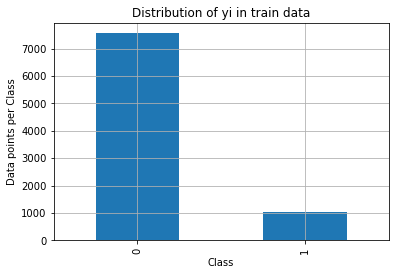

0    1889
1     259
Name: customer_category, dtype: int64


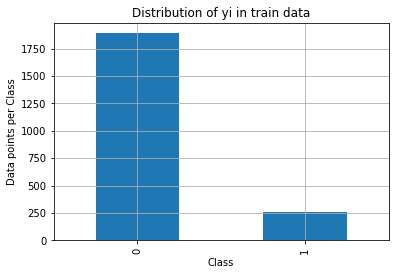

In [134]:
train_class_distribution = y_train.value_counts().sort_index()
print(train_class_distribution)

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()


cv_class_distribution = y_cv.value_counts().sort_index()
print(cv_class_distribution)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()


### The Train and CV dataset is having the similar distribution the two categories.

## The dataset is unbalanced since category '0' covers 87% of the dataset and Category '1' only 13%

### From the distribution of the dataset, It is better to use ML algorithms that handle imbalanced datas better than other algorithms. These include Decision Tree based algorithms since they use a tree approach and the minority class can have a small tree. We can also use SVMs by enabling the class_weight parameters as balanced.



## Feature Distributions

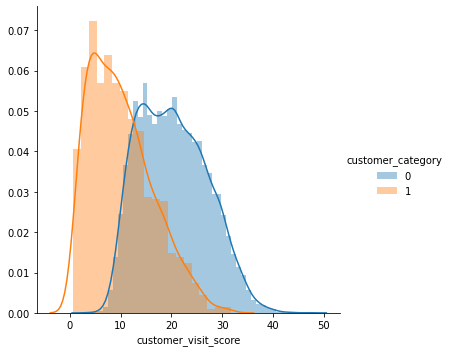

In [135]:
sns.FacetGrid(train_data, hue="customer_category", height=5) \
.map(sns.distplot, "customer_visit_score") \
.add_legend();
plt.show();


### Customer Visit Score - The distrubitions of the categories are overlapping hence it might be a less important feature as the values between 10 to 30 are overlapping for both 0 and 1

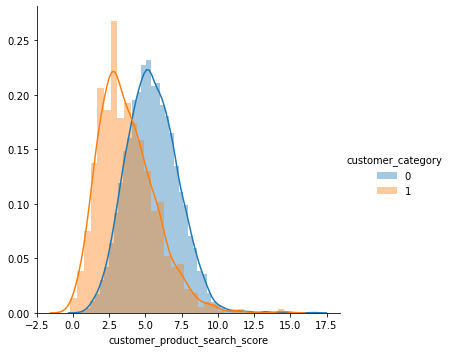

In [136]:
sns.FacetGrid(train_data, hue="customer_category", height=5) \
.map(sns.distplot, "customer_product_search_score") \
.add_legend();
plt.show();

### Customer Product Search Score - The distrubitions of the categories are highly overlapping which means that the feautre is not very important in deciding the categories as it would get difficult to seperate the data.

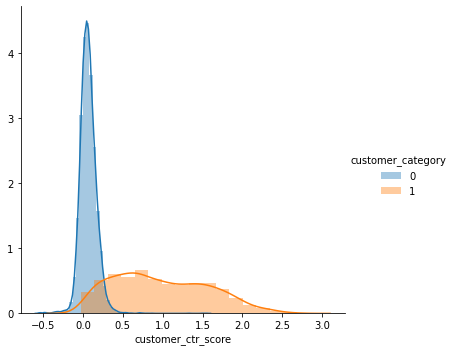

In [137]:
sns.FacetGrid(train_data, hue="customer_category", height=5) \
.map(sns.distplot, "customer_ctr_score") \
.add_legend();
plt.show();

### Customer Ctr score - This feature is very important as there is good amount of seperation between the category distributions. There is very less overlap compared to the previous features. 

### The features tells use the ratio of the number of clicked links to the number of searched links. The higher the ratio the more like the customer is in category 1.

### This might turn out to be the most important feature based on its distribution.

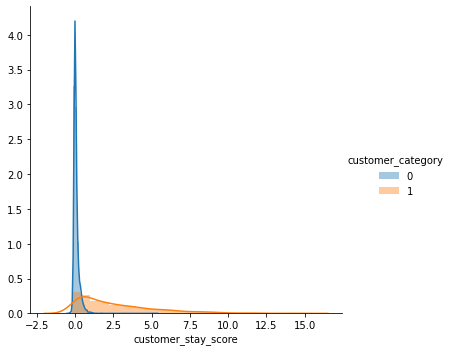

In [138]:
sns.FacetGrid(train_data, hue="customer_category", height=5) \
.map(sns.distplot, "customer_stay_score") \
.add_legend();
plt.show();

### Customer Stay Score - The distributions seems good for seperating the two category. Even though it is not as good as the Customer Ctr Score but it provides a good exclusiveness.

### The longer the customer stayed on the website, the customer becomes part of category 1.

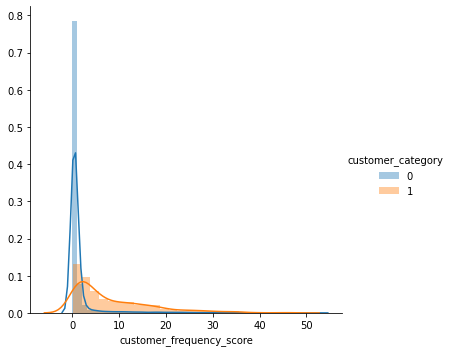

In [139]:
sns.FacetGrid(train_data, hue="customer_category", height=5) \
.map(sns.distplot, "customer_frequency_score") \
.add_legend();
plt.show();

### Customer Frequency Score - Similar to the Customer Stay score distribution but not as clearly distributed as the Customer Ctr score.

### The more visits the customer makes to the website, the customer is likely to put into the Cusomter '1' category.

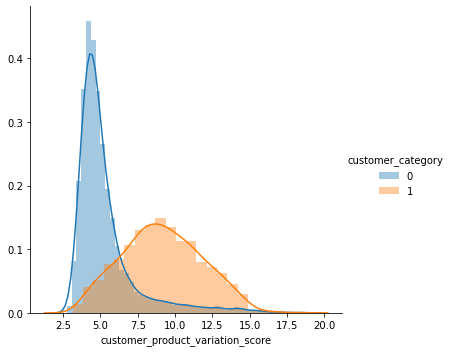

In [140]:
sns.FacetGrid(train_data, hue="customer_category", height=5) \
.map(sns.distplot, "customer_product_variation_score") \
.add_legend();
plt.show();

### Customer Product Variation Score - The distribution looks clear but on a closer notice we see the overlap in values of 0 and 1 till the end of the graph. 

### But we see that the customer who is more likely to check variety of products is more likely to be categorised as category 1 which may be the category for the person who purchased the product.

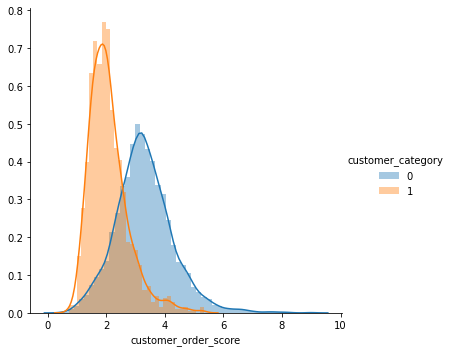

In [141]:
sns.FacetGrid(train_data, hue="customer_category", height=5) \
.map(sns.distplot, "customer_order_score") \
.add_legend();
plt.show();

### Customer Order Score - The distribution here is overlapping and not very conclusive in deciding the category.

### The customers of category 1 order but did not return the product, but customers of category 1 ordered very few products. From previous graphs we also note that the customer of category 1 did frequent visit, had variety of searches in deciding the order hence it is more likely for those customers not to return the product as they have verified it throughly before purchase.

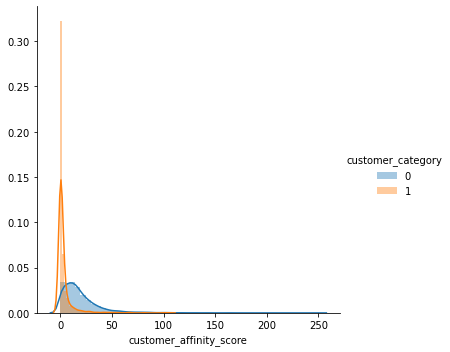

In [142]:
sns.FacetGrid(train_data, hue="customer_category", height=5) \
.map(sns.distplot, "customer_affinity_score") \
.add_legend();
plt.show();

### Customer Affinity Score - The Distribution here is average and but there is a overlap at the initial stages.

### The customer of category 1 has more affinity towards the website than with customer of category 0 which definitely affects the purchase decisions.


## ---------------------------------------------------------------------------------------------------------

# Machine Learning Solution

### Initially we use a Random Model as point of reference. Random model can be used as the worst performing model which randomly outputs the values. Hence any algorithm we use should perform better than this Random Model.

In [144]:
### Random Model Predicitions for conditional validation data

y_cv_predicted = np.random.randint(2, size=len(y_cv))

precision_score(y_cv, y_cv_predicted, average='macro')

0.49526050321054294

#### The Random Model provies a precision score of 49%, which means that our ML models should provide a much better score than this Random generated model

## Since the two columns "customer_active_segment" and "X1" are categorical data we cannot use it directly into ML algorithms but convert it to Numerical data.

## Here One Hot encoding is used in order to convert categorical data into numerical data.


In [147]:
vectorizer = CountVectorizer(token_pattern = r"(?u)\b\w+\b")
print(X_train['customer_active_segment'].unique())

# Fit only the train data
vectorizer.fit(X_train['customer_active_segment'].values)

# Convert text data to Vector
X_train_cas = vectorizer.transform(X_train['customer_active_segment'].values)
X_cv_cas = vectorizer.transform(X_cv['customer_active_segment'].values)
X_test_cas = vectorizer.transform(X_test['customer_active_segment'].values)


print("After vectorizations")
print(X_train_cas.shape, y_train.shape)
print(X_cv_cas.shape, y_cv.shape)
# print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)


['C' 'B' 'AA' 'D' 'A']
After vectorizations
(8590, 5) (8590,)
(2148, 5) (2148,)
['a', 'aa', 'b', 'c', 'd']


In [148]:
vectorizer = CountVectorizer(token_pattern = r"(?u)\b\w+\b")
print(X_train['X1'].unique())

# Fit only the train data
vectorizer.fit(X_train['X1'].values)

# Convert text data to Vector
X_train_x1 = vectorizer.transform(X_train['X1'].values)
X_cv_x1 = vectorizer.transform(X_cv['X1'].values)
X_test_x1 = vectorizer.transform(X_test['X1'].values)
print("After vectorizations")
print(X_train_x1.shape, y_train.shape)
print(X_cv_x1.shape, y_cv.shape)
print(vectorizer.get_feature_names())
print("="*100)


['AA' 'A' 'BA' 'F' 'E']
After vectorizations
(8590, 5) (8590,)
(2148, 5) (2148,)
['a', 'aa', 'ba', 'e', 'f']


### Checking the importance of customer_active_segment feature

In [149]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
depth = [1, 5, 10, 50]
split = [5, 10, 100, 500]
parameters = {'max_depth': depth, 'min_samples_split': split}
dtc = DecisionTreeClassifier(random_state=0)
clf = GridSearchCV(dtc, parameters, scoring='precision', n_jobs=-1, return_train_score=True)
clf.fit(X_train_cas, y_train)

clf.best_estimator_

DecisionTreeClassifier(max_depth=1, min_samples_split=5, random_state=0)

In [150]:
clf = DecisionTreeClassifier(max_depth=1, min_samples_split=5, random_state=0)
clf.fit(X_train_cas, y_train)

y_pred_cas = clf.predict(X_cv_cas)

print(precision_score(y_cv,y_pred_cas))

0.7352941176470589


### We see that the precision of the Random model was just 49% where as only by using the Customer active segment we get a precision score of 73.5%. Thus the Customer active segment is an important feature.

## --------------------------------------------------------------------------------------------------------------------------

### Checking the importance of X1 feature based on loyalty

In [151]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
depth = [1, 5, 10, 50]
split = [5, 10, 100, 500]
parameters = {'max_depth': depth, 'min_samples_split': split}
dtc = DecisionTreeClassifier(random_state=0)
clf = GridSearchCV(dtc, parameters, scoring='precision', n_jobs=-1, return_train_score=True)
clf.fit(X_train_x1, y_train)

clf.best_estimator_

DecisionTreeClassifier(max_depth=1, min_samples_split=5, random_state=0)

In [152]:
clf = DecisionTreeClassifier(max_depth=1, min_samples_split=5, random_state=0)
clf.fit(X_train_x1, y_train)

y_pred_x1 = clf.predict(X_cv_x1)

print(precision_score(y_cv,y_pred_x1))

0.0


### We see that the precision score for this feature is zero and seems like there is no value addition by this feature of X1 which is an anonymous number for loyalty.

## -------------------------------------------------------------------------------------------------------------------------------

## Using all features for predition the Category of the customer

In [153]:
# Dropping Customer Active Segment and X1 columns since we have convert categorical to numerical data into different variables

X_train = X_train.drop("customer_active_segment", axis=1)
X_train = X_train.drop("X1", axis=1)

print(X_train.columns)

Index(['customer_visit_score', 'customer_product_search_score',
       'customer_ctr_score', 'customer_stay_score', 'customer_frequency_score',
       'customer_product_variation_score', 'customer_order_score',
       'customer_affinity_score'],
      dtype='object')


In [154]:
X_cv = X_cv.drop("customer_active_segment", axis=1)
X_cv = X_cv.drop("X1", axis=1)

print(X_cv.columns)

Index(['customer_visit_score', 'customer_product_search_score',
       'customer_ctr_score', 'customer_stay_score', 'customer_frequency_score',
       'customer_product_variation_score', 'customer_order_score',
       'customer_affinity_score'],
      dtype='object')


### We are not doing the same for test data now since we are testing the best algorithm and use CV data for testing.
### Once the algorithm is decided upon we can convert the test data too.

In [155]:
# Stacking the The main features and the converted numerical "customer active segment" and "X1" features.

from scipy.sparse import hstack
X_tr = hstack((X_train, X_train_cas, X_train_x1))
X_cr = hstack((X_cv, X_cv_cas, X_cv_x1))

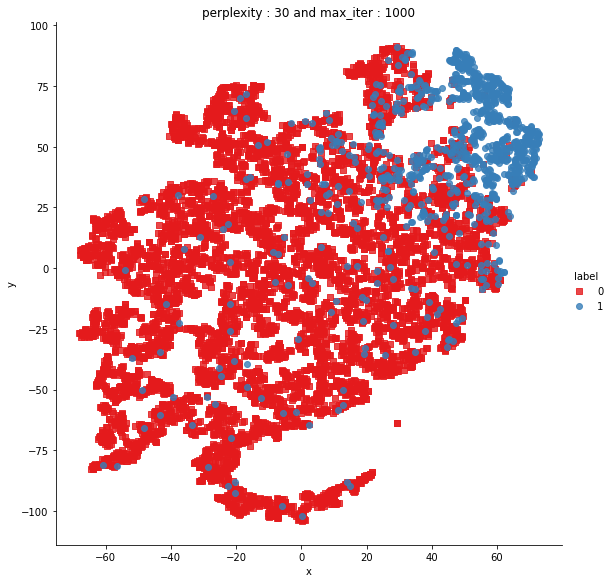

In [156]:
import numpy as np
from sklearn.manifold import TSNE

perplexity = 30
X_embedded = TSNE(n_components=2,n_iter=1000, perplexity=perplexity).fit_transform(X_tr)

df = pd.DataFrame({'x':X_embedded[:,0], 'y':X_embedded[:,1] ,'label':y_train})

sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(perplexity, 1000))
plt.show()

### From the TSNE Graph we see that most of the Blue points of category 1 are seperable from category 0. However there are blue points which are overlapping over the red points for which we can use the ML Algorithms.

## Starting with Hyperparameter tuning of Decision Trees since DTs are well known to handle imbalanced data.

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
depth = [1, 5, 10, 50]
split = [5, 10, 100, 500]
parameters = {'max_depth': depth, 'min_samples_split': split}
dtc = DecisionTreeClassifier(random_state=0)
clf = GridSearchCV(dtc, parameters, scoring='precision', n_jobs=-1, return_train_score=True)
clf.fit(X_tr, y_train)

clf.best_estimator_

DecisionTreeClassifier(max_depth=1, min_samples_split=5, random_state=0)

In [61]:
clf = DecisionTreeClassifier(max_depth=1, min_samples_split=5, random_state=0)
clf.fit(X_tr, y_train)

y_pred_cv = clf.predict(X_cr)

print("Precision Score : Decision Tree: ",precision_score(y_cv,y_pred_cv))

Precision Score : Decision Tree:  0.9354838709677419


[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


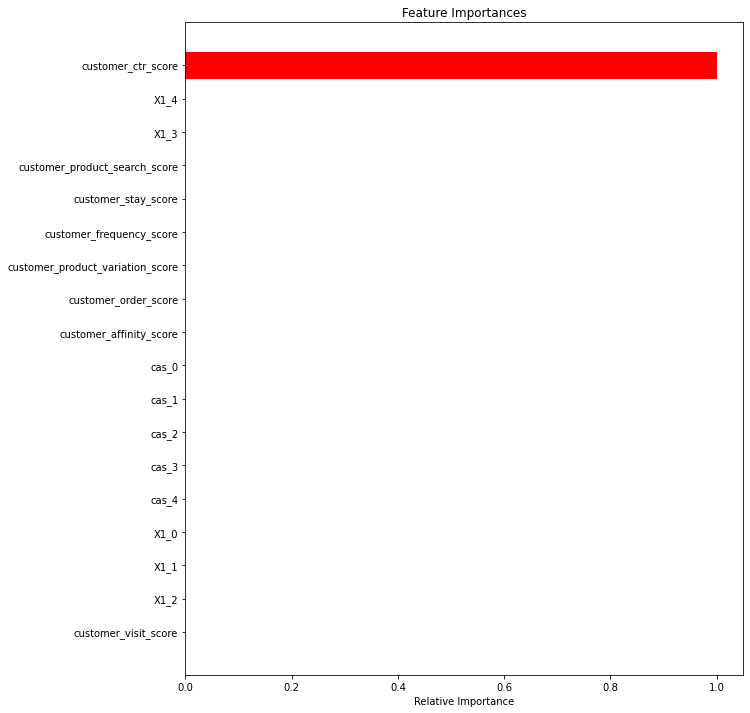

In [66]:
feature_columns = ['customer_visit_score', 'customer_product_search_score',
       'customer_ctr_score', 'customer_stay_score', 'customer_frequency_score',
       'customer_product_variation_score', 'customer_order_score',
       'customer_affinity_score', 'cas_0', 'cas_1', 'cas_2', 'cas_3', 'cas_4', 'X1_0', 'X1_1', 'X1_2', 'X1_3', 'X1_4',]
features = feature_columns
importances = clf.feature_importances_
print(importances)
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Using Decision Tree we get a precision score of 93.5% which is very good compared to our random model discussed in the beginning at 51%

In [71]:

import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_grid = {
        'max_depth': [3, 5, 10],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'subsample': [0.6, 0.8, 1],
        'colsample_bytree': [0.6, 0.8, 1],
        'colsample_bylevel': [0.6, 0.8, 1],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 10, 100],
        'n_estimators': [10, 50, 100, 200]}

clf = xgb.XGBClassifier(n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_grid,
                                   n_iter=5,cv=5,scoring='f1',random_state=25, return_train_score=True)

rf_random.fit(X_tr,y_train)
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
              colsample_bynode=1, colsample_bytree=1, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [72]:
clf_xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
              colsample_bynode=1, colsample_bytree=1, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Converting Sparse matrix to Dataframe for compatibility with XG Boost
X_tr_df = pd.DataFrame.sparse.from_spmatrix(X_tr)
X_cr_df = pd.DataFrame.sparse.from_spmatrix(X_cr)

clf_xgb.fit(X_tr_df,y_train)
y_pred_cv = clf_xgb.predict(X_cr_df)

print(precision_score(y_cv,y_pred_cv))

0.9435483870967742


### Using XG Boosting we tend to get a better result by the column sampling provided by the algorithm which prevents the algorithm from overfitting. Here Hyperparameter tuning of the XG Boost is done in order to provide best possible results.

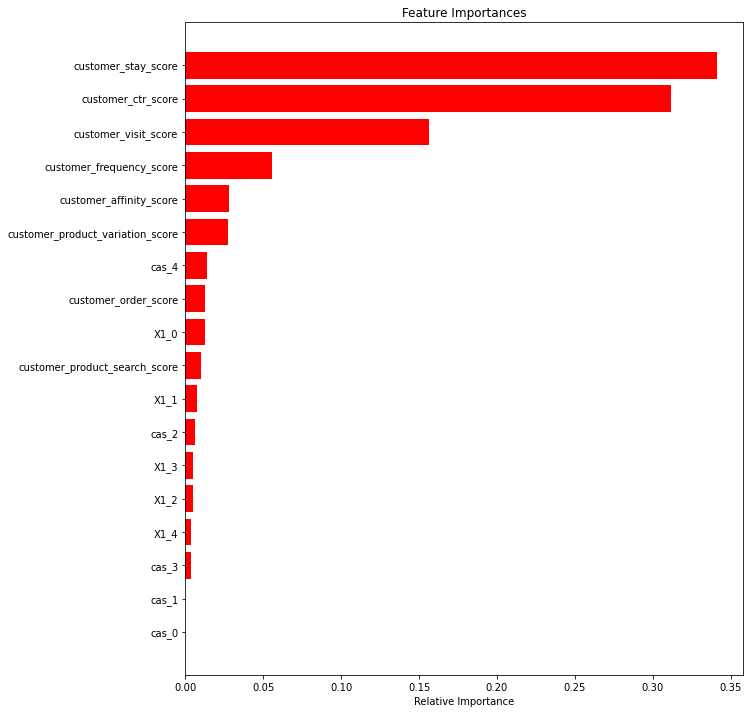

In [73]:
feature_columns = ['customer_visit_score', 'customer_product_search_score',
       'customer_ctr_score', 'customer_stay_score', 'customer_frequency_score',
       'customer_product_variation_score', 'customer_order_score',
       'customer_affinity_score', 'cas_0', 'cas_1', 'cas_2', 'cas_3', 'cas_4', 'X1_0', 'X1_1', 'X1_2', 'X1_3', 'X1_4',]
features = feature_columns
importances = clf_xgb.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### We see the relative feature importance of each of the features.

### Customer Stay score seems to have highest importance followed by Customer Ctr score and Customer visit score.

### Customer frequency score also adds a good amount of feature importance. Thus overall the time spent and the number of times the customer visits the website seems to be very important in deciding the category.

In [87]:
from sklearn.svm import SVC

X_tr_df = pd.DataFrame.sparse.from_spmatrix(X_tr)
X_cr_df = pd.DataFrame.sparse.from_spmatrix(X_cr)

X_tr_np = X_tr_df.to_numpy()
X_cr_np = X_cr_df.to_numpy()


svc = SVC(C=35, class_weight="balanced", kernel='rbf')

svc.fit(X_tr_np, y_train)

y_pred_cv = svc.predict(X_cr_np)

print(precision_score(y_cv,y_pred_cv))

0.8768115942028986


### SVM with the rbf kernel provided a precision score of 87% after various hyperparameter trials.

### Since we have tried the ones that can handle imbalanced data well, we can give a try to other ML algorithms which are average in handling imabalanced data.

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

params = {
    'n_neighbors': [3, 5, 7, 10, 20],
    'weights': ['uniform','distance'],
    'metric': ['euclidean', 'manhattan']
}


knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, params, verbose=1, cv=5, n_jobs=-1)

grid_search.fit(X_tr_df, y_train)

print(grid_search.best_estimator_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.7s


KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.0s finished


In [95]:
clf_knn = KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')

clf_knn.fit(X_tr_df,y_train)

y_pred_cv = clf_knn.predict(X_cr_df)

print(precision_score(y_cv,y_pred_cv))

0.9569377990430622


### KNN is able to provide a good precision score even compared to that of the XG Boost DTs but need to verify once trained with larger dataset and with the test dataset.

In [97]:
LR = LogisticRegression(random_state=0)

penalty = ['l1', 'l2']
C = np.logspace(0.001, 100, 10)
hyperparameters = dict(C=C, penalty=penalty)

clf = GridSearchCV(LR, hyperparameters, scoring='f1')
best_model = clf.fit(X_tr_df, y_train)
print(best_model.best_estimator_)

LogisticRegression(C=129419584144.99811, random_state=0)


In [100]:
log_reg=LogisticRegression(C=129419584144.99811, random_state=0)
log_reg.fit(X_tr_df, y_train)

y_cv_pred = log_reg.predict(X_cr_df)
print(precision_score(y_cv,y_cv_pred))

0.9471544715447154


In [ ]:
## Logistic regression is also able to provide similar accuracy compared to the XG Boost.

### Since we have three well performing ML algorithms for this dataset we can use stacking in order to check if we get good results.


In [101]:
clf1 = KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')
clf2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
              colsample_bynode=1, colsample_bytree=1, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)
clf3 =  DecisionTreeClassifier(max_depth=1, min_samples_split=5, random_state=0)
lr = LogisticRegression()

sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=False,
                          average_probas=False,
                          meta_classifier=lr)


sclf.fit(X_tr_df,y_train)
y_cv_pred = sclf.predict(X_cr_df)

print(precision_score(y_cv,y_cv_pred))


0.9569377990430622


### The stacking classifier is providing the same result as that of the KNN. 

## Hence for the complete train dataset we can use "XGboost" and "KNN" and choose the best among them for final result.

## ----------------------------------------------------------------------------------------------------------------------------------

In [102]:
train_data=pd.read_csv('train.csv')
train_data.head()

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
0,csid_1,13.168425,9.447662,-0.070203,-0.139541,0.436956,4.705761,2.537985,7.959503,C,F,0
1,csid_2,17.092979,7.329056,0.153298,-0.102726,0.380340,4.205138,4.193444,17.517381,C,A,0
2,csid_3,17.505334,5.143676,0.106709,0.262834,0.417648,4.479070,3.878971,12.595155,C,BA,0
3,csid_4,31.423381,4.917740,-0.020226,-0.100526,0.778130,5.055535,2.708940,4.795073,AA,F,0
4,csid_5,11.909502,4.237073,0.187178,0.172891,0.162067,3.445247,3.677360,56.636326,C,AA,0


In [103]:
test_data=pd.read_csv('test.csv')
test_data.head()

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1
0,csid_10739,22.500174,3.702145,0.118811,0.093253,0.689237,5.786842,3.748009,7.661716,B,BA
1,csid_10740,13.225950,3.600102,0.130985,0.053575,0.142756,3.940359,3.469659,33.999679,B,AA
2,csid_10741,14.603376,5.084047,-0.004651,-0.036299,0.333709,4.254662,3.855939,33.485630,B,AA
3,csid_10742,26.149905,3.025501,0.229740,0.204591,3.768405,6.942625,2.362421,0.795372,B,BA
4,csid_10743,19.810630,5.020400,-0.011347,-0.028780,0.286841,4.585513,3.278624,15.052058,C,BA


In [104]:
# Replacing Null value of each column with the respective Mean value.
for each_column in train_data.columns[1:9]:
    mean_value = train_data[each_column].mean()
    train_data[each_column].fillna(mean_value, inplace=True)
    test_data[each_column].fillna(mean_value, inplace=True)

In [105]:
train_data["customer_active_segment"].fillna("C", inplace=True)
test_data["customer_active_segment"].fillna("C", inplace=True)

train_data["X1"].fillna("BA", inplace=True)
test_data["X1"].fillna("BA", inplace=True)

In [106]:
print("Any Null values in Train and Test data ==> ", train_data.isnull().any().any(),test_data.isnull().any().any())
print("*"*50)
print(train_data.isna().sum())
print("*"*50)
print(test_data.isna().sum())

Any Null values in Train and Test data ==>  False False
**************************************************
customer_id                         0
customer_visit_score                0
customer_product_search_score       0
customer_ctr_score                  0
customer_stay_score                 0
customer_frequency_score            0
customer_product_variation_score    0
customer_order_score                0
customer_affinity_score             0
customer_active_segment             0
X1                                  0
customer_category                   0
dtype: int64
**************************************************
customer_id                         0
customer_visit_score                0
customer_product_search_score       0
customer_ctr_score                  0
customer_stay_score                 0
customer_frequency_score            0
customer_product_variation_score    0
customer_order_score                0
customer_affinity_score             0
customer_active_segment        

In [107]:
### Drop Customer id since it is unique and not needed for training

X_train = train_data.drop("customer_id", axis=1)
X_test = test_data.drop("customer_id", axis=1)

print(X_train.columns)
print(X_test.columns)

Index(['customer_visit_score', 'customer_product_search_score',
       'customer_ctr_score', 'customer_stay_score', 'customer_frequency_score',
       'customer_product_variation_score', 'customer_order_score',
       'customer_affinity_score', 'customer_active_segment', 'X1',
       'customer_category'],
      dtype='object')
Index(['customer_visit_score', 'customer_product_search_score',
       'customer_ctr_score', 'customer_stay_score', 'customer_frequency_score',
       'customer_product_variation_score', 'customer_order_score',
       'customer_affinity_score', 'customer_active_segment', 'X1'],
      dtype='object')


In [108]:
y_train = X_train["customer_category"]

X_train = X_train.drop("customer_category", axis=1)

print(X_train.columns)

Index(['customer_visit_score', 'customer_product_search_score',
       'customer_ctr_score', 'customer_stay_score', 'customer_frequency_score',
       'customer_product_variation_score', 'customer_order_score',
       'customer_affinity_score', 'customer_active_segment', 'X1'],
      dtype='object')


In [109]:
vectorizer = CountVectorizer(token_pattern = r"(?u)\b\w+\b")
print(X_train['customer_active_segment'].unique())
vectorizer.fit(X_train['customer_active_segment'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_cas = vectorizer.transform(X_train['customer_active_segment'].values)
X_test_cas = vectorizer.transform(X_test['customer_active_segment'].values)
print("After vectorizations")
print(X_train_cas.shape, y_train.shape)
# print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

['C' 'AA' 'B' 'A' 'D']
After vectorizations
(10738, 5) (10738,)
['a', 'aa', 'b', 'c', 'd']


In [110]:
vectorizer = CountVectorizer(token_pattern = r"(?u)\b\w+\b")
print(X_train['X1'].unique())
vectorizer.fit(X_train['X1'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_x1 = vectorizer.transform(X_train['X1'].values)
X_test_x1 = vectorizer.transform(X_test['X1'].values)
print("After vectorizations")
print(X_train_x1.shape, y_train.shape)
# print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)


['F' 'A' 'BA' 'AA' 'E']
After vectorizations
(10738, 5) (10738,)
['a', 'aa', 'ba', 'e', 'f']


In [111]:
X_train = X_train.drop("customer_active_segment", axis=1)
X_train = X_train.drop("X1", axis=1)

X_test = X_test.drop("customer_active_segment", axis=1)
X_test = X_test.drop("X1", axis=1)

In [112]:
from scipy.sparse import hstack
X_tr = hstack((X_train, X_train_cas, X_train_x1))
X_te = hstack((X_test, X_test_cas, X_test_x1))

# XG Boost DT

In [113]:
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_grid = {
        'max_depth': [3, 5, 10],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'subsample': [0.6, 0.8, 1],
        'colsample_bytree': [0.6, 0.8, 1],
        'colsample_bylevel': [0.6, 0.8, 1],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 10, 100],
        'n_estimators': [10, 50, 100, 200]}

clf = xgb.XGBClassifier(n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_grid,
                                   n_iter=5,cv=5,scoring='f1',random_state=25, return_train_score=True)

rf_random.fit(X_tr,y_train)
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
              colsample_bynode=1, colsample_bytree=1, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [120]:
clf_xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
              colsample_bynode=1, colsample_bytree=1, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)
            
X_tr_df = pd.DataFrame.sparse.from_spmatrix(X_tr)
clf_xgb.fit(X_tr_df,y_train)

X_te_df = pd.DataFrame.sparse.from_spmatrix(X_te)
y_pred = clf_xgb.predict(X_te_df)

print(y_pred)

[0 0 0 ... 0 0 1]


In [115]:
print(test_data.shape, y_pred.shape)

result_dict = {
    "customer_id": test_data["customer_id"],
    "customer_category":y_pred
}

result = pd.DataFrame(result_dict)

print(result.head())

result.to_csv(r"Result_xgb.csv",index = False, header=True)

(7160, 11) (7160,)
  customer_id  customer_category
0  csid_10739                  0
1  csid_10740                  0
2  csid_10741                  0
3  csid_10742                  0
4  csid_10743                  0


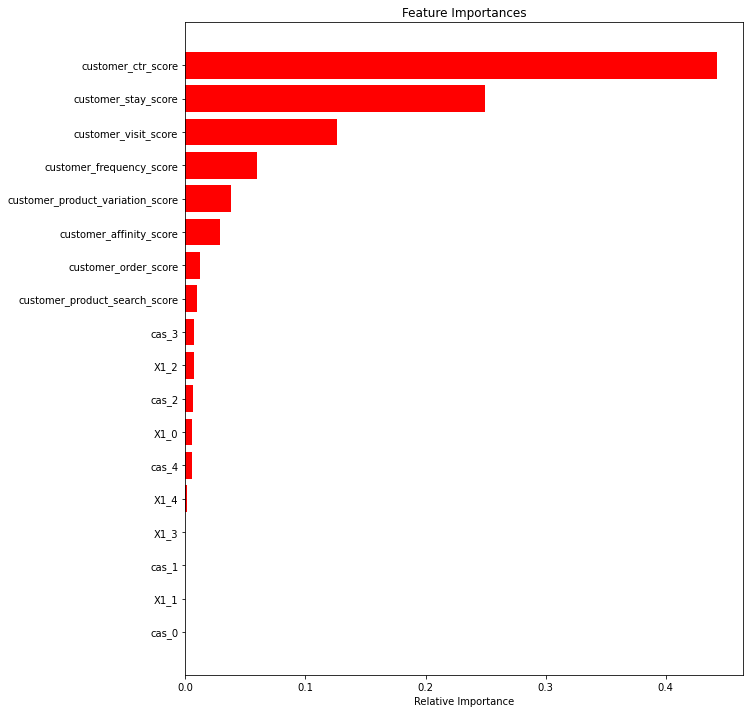

In [121]:
feature_columns = ['customer_visit_score', 'customer_product_search_score',
       'customer_ctr_score', 'customer_stay_score', 'customer_frequency_score',
       'customer_product_variation_score', 'customer_order_score',
       'customer_affinity_score', 'cas_0', 'cas_1', 'cas_2', 'cas_3', 'cas_4', 'X1_0', 'X1_1', 'X1_2', 'X1_3', 'X1_4',]
features = feature_columns
importances = clf_xgb.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## XG Boost was able to provide a precision score of 92.16268

# KNN

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

params = {
    'n_neighbors': [3, 5, 7, 10, 20],
    'weights': ['uniform','distance'],
    'metric': ['euclidean', 'manhattan']
}


knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, params, verbose=1, cv=5, n_jobs=-1)

grid_search.fit(X_tr_df, y_train)

print(grid_search.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.1s


KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.8s finished


In [118]:
clf_knn = KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')

clf_knn.fit(X_tr_df,y_train)

y_pred = clf_knn.predict(X_te_df)

In [119]:
print(test_data.shape, y_pred.shape)

result_dict = {
    "customer_id": test_data["customer_id"],
    "customer_category":y_pred
}

result = pd.DataFrame(result_dict)

print(result.head())

result.to_csv(r"Result_knn.csv",index = False, header=True)

(7160, 11) (7160,)
  customer_id  customer_category
0  csid_10739                  0
1  csid_10740                  0
2  csid_10741                  0
3  csid_10742                  0
4  csid_10743                  0


## KNN was able to provide a precision score of 91.81054

## -------------------------------------------------------------------------------------------------------------------------------

# Conclusion

### We can see that XGBoost DT was the best classifier in terms of providing the best precision score of 92.16268

### We can assume that the category "0" is for the customer who did not take much time in deciding a product nor did the customer invest in research of the product of interest, where as the category "1" customers researched a lot before buying any product of interest.

### The top 3 feature importance were in decreasing order 1. Customer Ctr Score 2. Customer Stay score 3. Customer visit score

### Which shows that the higher ratio of the clicks to search , the easier it is to categorise the customer
### The more time the customer spent on the website, the customer was more likely to be categorised into "1" which may be that the customer bought something
### The more the customer visits the websites, the more chance he is going to be categorised into category "1"